#17.12

<ipython-input-50-5aaf68d2aaa3>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['number_sold'].resample('M').sum()


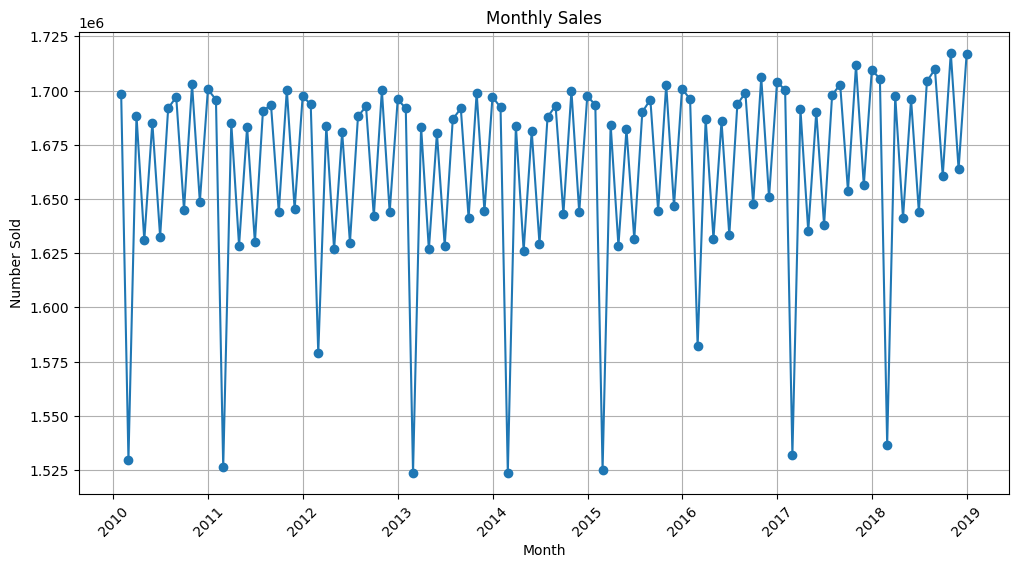

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

monthly_sales = df['number_sold'].resample('M').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Number Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Небольшой восходящий тренд, заметны регулярные пики и спады. Каждый год в определенные месяцы (особенно февраль) продажи падают до минимальных значений, а затем снова поднимаются.

In [52]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
  result = adfuller(data)

  print('ADF Statistic:', result[0])
  print('p-value:', result[1])

  if result[1] <= 0.05:
      print("Временной ряд стационарен")
  else:
      print("Временной ряд нестационарен")

In [25]:
adfuller_test(monthly_sales)

ADF Statistic: 0.5343272139492727
p-value: 0.9858799331312138
Временной ряд нестационарен


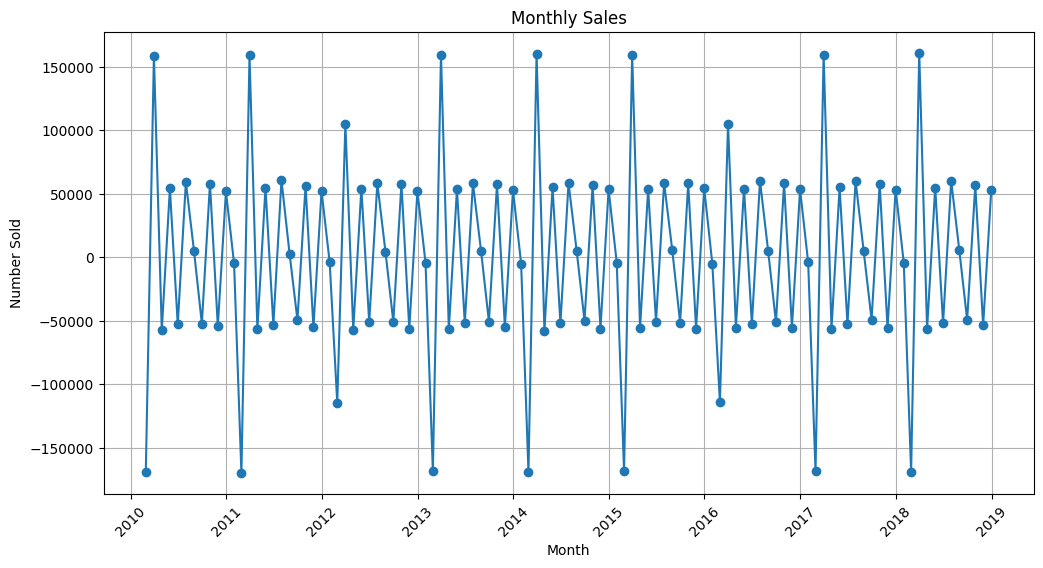

In [26]:
monthly_sales_diff= monthly_sales.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_diff.index, monthly_sales_diff.values, marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Number Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [27]:
adfuller_test(monthly_sales_diff)

ADF Statistic: -28.855441988661354
p-value: 0.0
Временной ряд стационарен


Сезонность присутствует, поэтому применяем Sarima

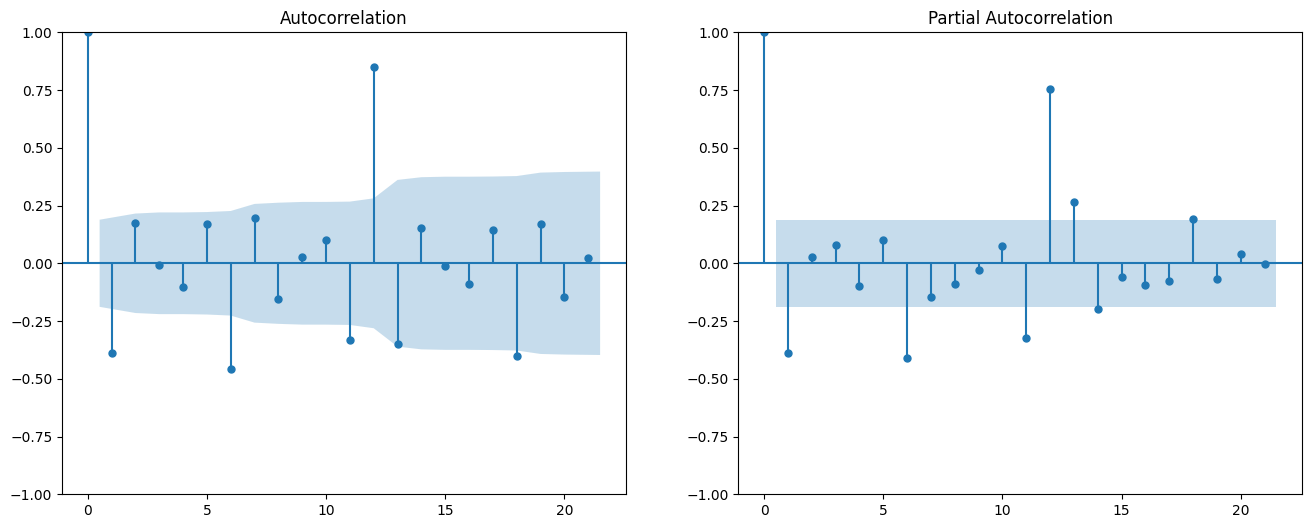

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(monthly_sales, ax=axes[0])
plot_pacf(monthly_sales, ax=axes[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


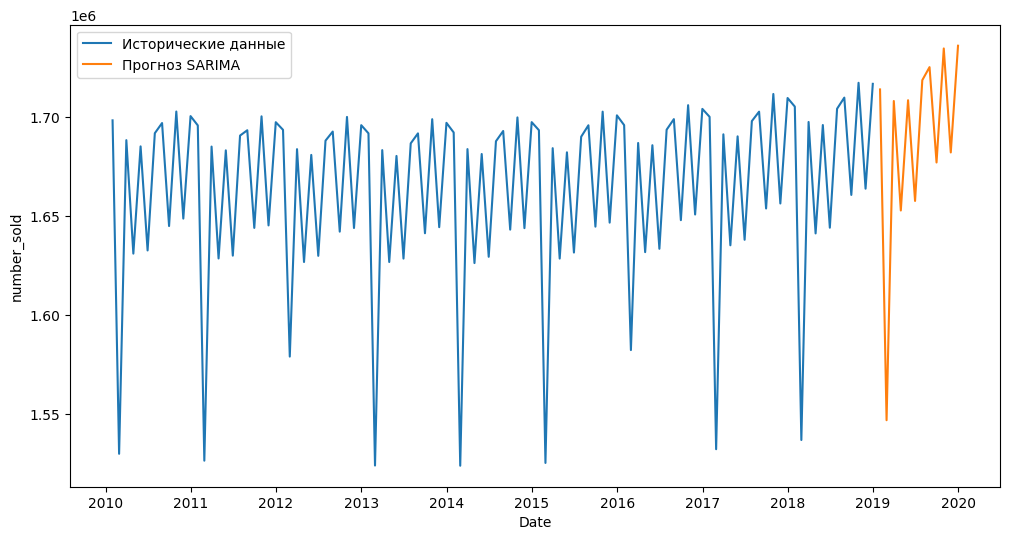

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

model_sarima = SARIMAX(monthly_sales, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12), trend='c').fit()

forecast_sarima = model_sarima.predict(start=len(monthly_sales), end=len(monthly_sales)+11, typ='levels')

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, label='Исторические данные')
sns.lineplot(data=forecast_sarima, label='Прогноз SARIMA')
plt.show()

In [75]:
test_df = pd.read_csv('test.csv')

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)
monthly_test_sales = test_df['number_sold'].resample('MS').sum()

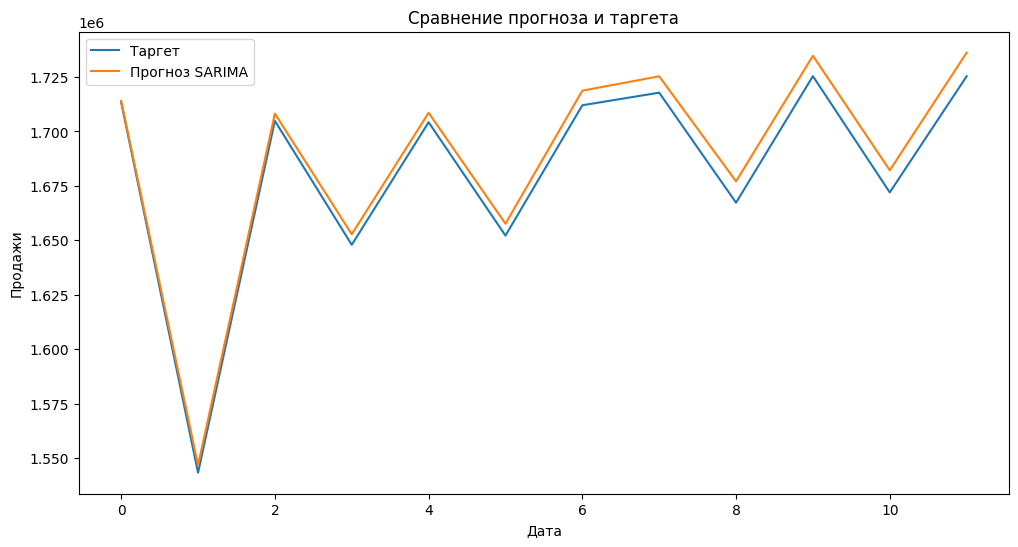

In [76]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_test_sales.values, label='Таргет')
sns.lineplot(data=forecast_sarima.values, label='Прогноз SARIMA')
plt.title('Сравнение прогноза и таргета')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()

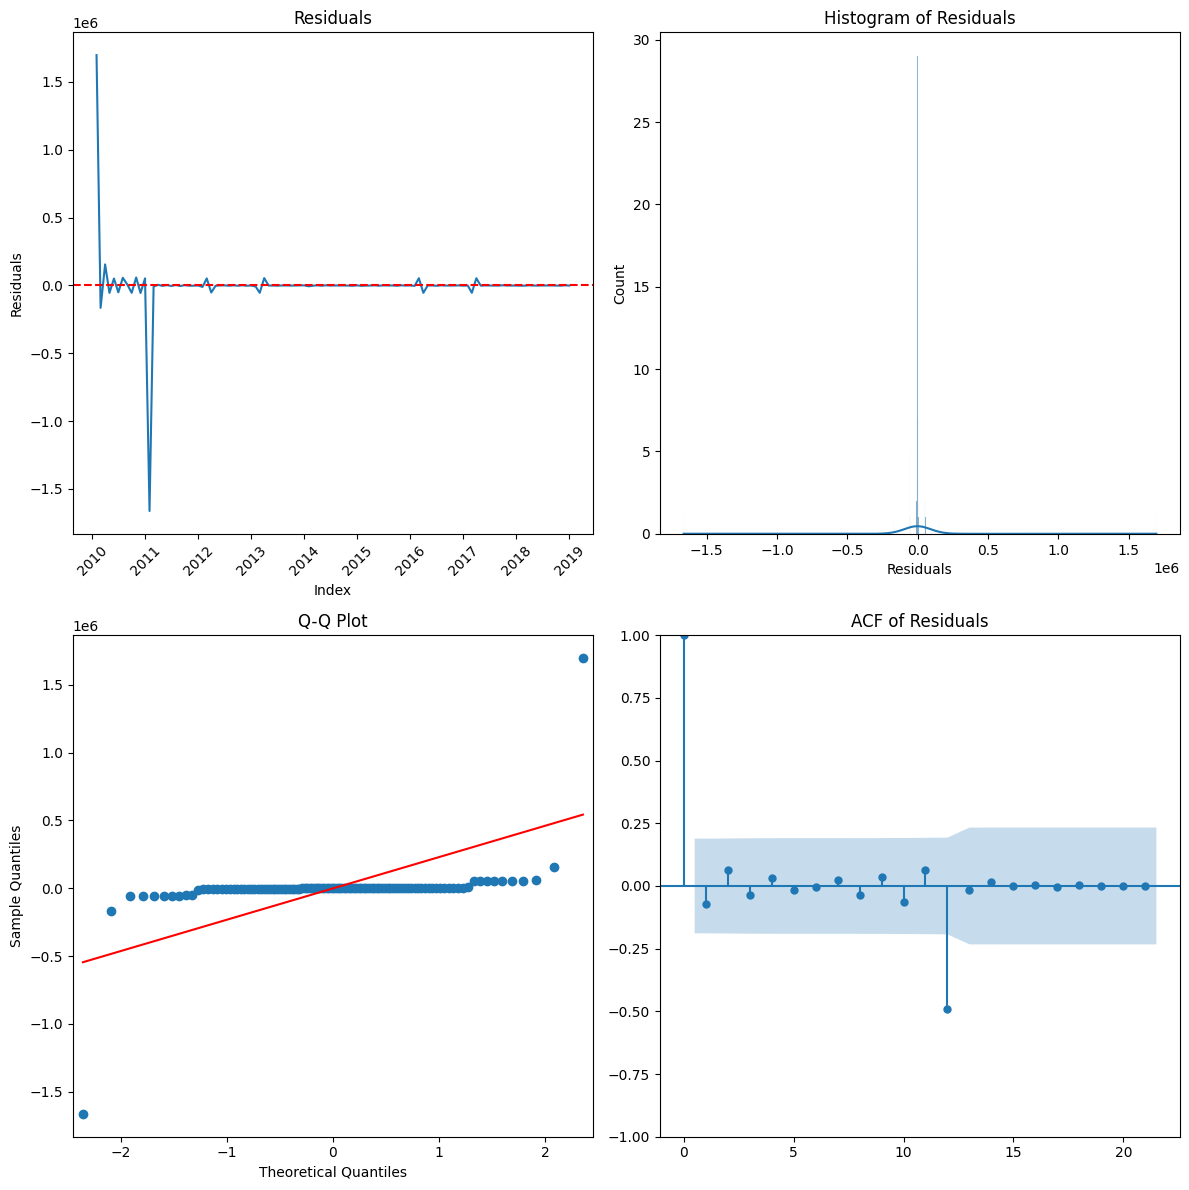


Shapiro-Wilk test results:
W: 0.21263559244131724, p-value: 1.810435398296137e-21


In [77]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

residuals = model_sarima.resid

# 1. График остатков
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Index')
plt.xticks(rotation=45)
plt.ylabel('Residuals')

# 2. Гистограмма остатков
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

# 3. Q-Q plot для проверки нормальности
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

# 4. ACF Plot для проверки автокорреляции остатков
plt.subplot(2, 2, 4)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# 6. Тест на нормальность остатков (тест Шапиро-Уилка)
shapiro_test = shapiro(residuals)
print(f"\nShapiro-Wilk test results:\nW: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

In [78]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(monthly_test_sales, forecast_sarima)

# Вычисление RMSE
rmse_value = np.sqrt(mean_squared_error(monthly_test_sales, forecast_sarima))

# Вычисление R²
r2 = r2_score(monthly_test_sales, forecast_sarima)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse_value:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 0.38%
RMSE: 7073.32
R²: 0.98
